In [16]:
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from numba import njit

from astropy import units as u
import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set ('latest')

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
from gala.units import galactic

from joblib import Parallel, delayed
import pickle

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
Naidu_idx = 100
arepo_idx = 2000

In [4]:
sn = {}
sn['Naidu21'] = {}

sn['Naidu21']['lo'] = {}
sn['Naidu21']['lo'][0] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                        'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_000')
sn['Naidu21']['lo'][Naidu_idx] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                          'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_'+str(Naidu_idx).zfill(3))
# sn['Naidu21']['lo'][500] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims/'+
                                          # 'z2merger_M1_UM/grid/129_129_50_pro_165/snapshot_500')
print('Naidu21 times')
for idx in sn['Naidu21']['lo'].keys():
    print(idx, sn['Naidu21']['lo'][idx].Time)

# sn['Naidu21']['hi'] = {}
# sn['Naidu21']['hi'][0] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
                                        # '/fiducial/129_129_50_pro_165/snapshot_000')
# sn['Naidu21']['hi'][500] = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/sims'+
                                          # '/fiducial/129_129_50_pro_165/snapshot_500')

sn['arepoRN'] = {}
sn['arepoRN']['lo'] = {}
sn['arepoRN']['lo'][0] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs/output', 0, combineFiles=True)
sn['arepoRN']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MWN0_GSEN0/lvlRN-nofs/output', arepo_idx, combineFiles=True)
print('arepoRN times')
for idx in sn['arepoRN']['lo'].keys():
    print(idx, sn['arepoRN']['lo'][idx].Time)

    
# sn['gas'] = {}
# sn['gas']['lo'] = {}
# sn['gas']['lo'][0] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2/lvl4/output', 0, combineFiles=True)
# sn['gas']['lo'][arepo_idx] = arepo.Snapshot(basepath + 'runs/MW3_MHG0.25_GSE2/lvl4/output', arepo_idx, combineFiles=True)

Naidu21 times
0 0.0
100 9.999999962747097
arepoRN times
0 0.0
2000 10.0


[(-135.0, -115.0), (-10.0, 10.0), None]

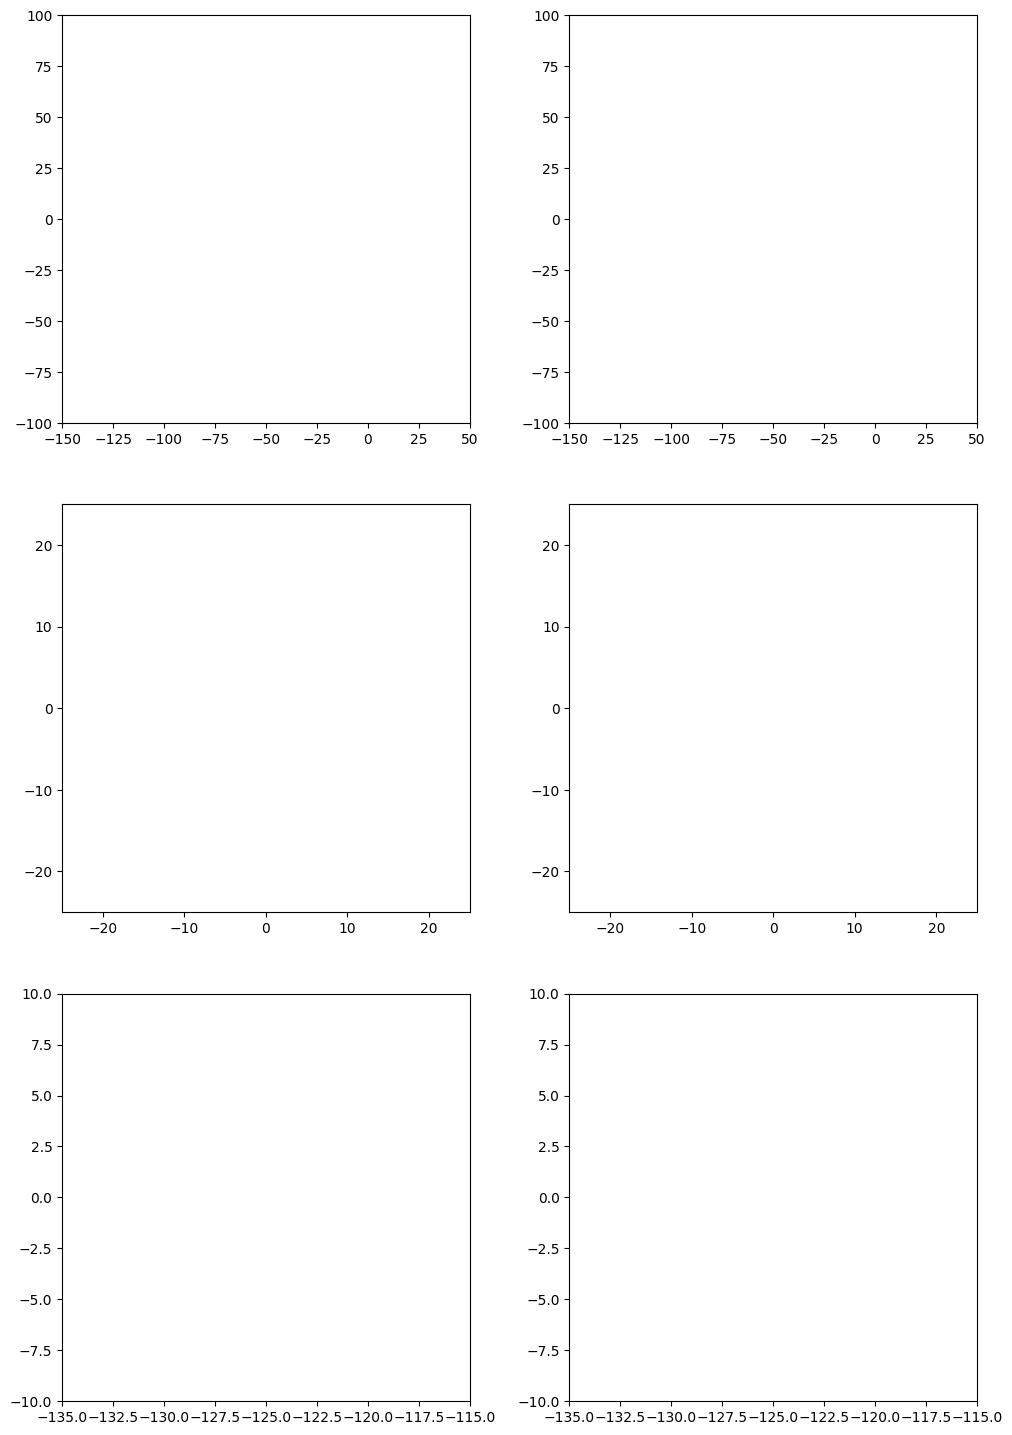

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

sn_ = sn['Naidu21']['lo'][Naidu_idx]
# subsample = np.random.choice(np.arange(sn_.NumPart_Total[2]), sn_.NumPart_Total[2]//8, replace=False)
# ax[0][0].scatter(sn_.part2.pos[:,0][subsample], sn_.part2.pos[:,1][subsample], s=0.1)
# ax[1][0].scatter(sn_.part2.pos[:,0][subsample], sn_.part2.pos[:,1][subsample], s=0.1)
# ax[2][0].scatter(sn_.part2.pos[:,0][subsample], sn_.part2.pos[:,1][subsample], s=0.1)

ax[0][0].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)
ax[1][0].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)
ax[2][0].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)


sn_ = sn['arepoRN']['lo'][arepo_idx]
ax[0][1].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)
ax[1][1].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)
ax[2][1].scatter(sn_.part2.pos[:,0], sn_.part2.pos[:,1], s=0.1)

ax[0][0].set(xlim=(-150, 50), ylim=(-100, 100), aspect='equal')
ax[0][1].set(xlim=(-150, 50), ylim=(-100, 100), aspect='equal')
ax[1][0].set(xlim=(-25, 25), ylim=(-25, 25), aspect='equal')
ax[1][1].set(xlim=(-25, 25), ylim=(-25, 25), aspect='equal')
ax[2][0].set(xlim=(-135, -115), ylim=(-10, 10), aspect='equal')
ax[2][1].set(xlim=(-135, -115), ylim=(-10, 10), aspect='equal')


In [6]:
def get_in_GSE(sn, sn0, center=np.array([0, 0, 0])):
    r = np.linalg.norm(sn0.part2.pos - center, axis=1)
    in_GSE0 = r > 40
    in_MW0 = np.logical_not(in_GSE0)
    GSE_ID_min = np.min(sn0.part2.id[in_GSE0])
    GSE_ID_max = np.max(sn0.part2.id[in_GSE0])

    MW_ID_min = np.min(sn0.part2.id[in_MW0])
    MW_ID_max = np.max(sn0.part2.id[in_MW0])
    # print(np.min(sn_rn0.part2.id[in_GSE]), np.max(sn_rn0.part2.id[in_GSE]))
    # print(np.min(sn_rn0.part2.id[in_MW]), np.max(sn_rn0.part2.id[in_MW]))
    
    in_GSE = np.logical_and(sn.part2.id >= GSE_ID_min, sn.part2.id <= GSE_ID_max)
    in_MW = np.logical_and(sn.part2.id >= MW_ID_min, sn.part2.id <= MW_ID_max)
    
    return in_MW, in_GSE

def _get_COM(pos, vel, rmin=1, rmax=20, rfac=0.9):
    COM = np.mean(pos, axis=0)
    r = np.linalg.norm(pos-COM, axis=1)
    
    rcut = rmax
    while rcut > rmin:
        COM = np.mean(pos[r<rcut], axis=0)
        r = np.linalg.norm(pos-COM, axis=1)
        rcut *= rfac
    
    COMV = np.mean(vel[r<rcut], axis=0)
    
    return COM, COMV

def get_COM(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV = _get_COM(pos_MW, vel_MW)
    GSE_COM, GSE_COMV = _get_COM(pos_GSE, vel_GSE)
    
    return MW_COM, MW_COMV, GSE_COM, GSE_COMV

In [7]:
in_MW_RN, in_GSE_RN = get_in_GSE(sn['Naidu21']['lo'][Naidu_idx], sn['Naidu21']['lo'][0])
in_MW_arepo, in_GSE_arepo = get_in_GSE(sn['arepoRN']['lo'][arepo_idx], sn['arepoRN']['lo'][0])
# in_MW_gas, in_GSE_gas = get_in_GSE(sn['gas']['lo'][arepo_idx], sn['gas']['lo'][0], center=np.array([300, 300, 300]))

In [8]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
MW_COM_RN, MW_COMV_RN, GSE_COM_RN, GSE_COMV_RN = get_COM(sn_, sn['Naidu21']['lo'][0])
# GSE_COM_RN = np.mean(sn_.part2.pos[in_GSE_RN], axis=0)
# GSE_COMV_RN = np.mean(sn_.part2.vel[in_GSE_RN], axis=0)
print('GSE_COM', GSE_COM_RN - MW_COM_RN)
print('GSE_COMV', GSE_COMV_RN - MW_COMV_RN)
mass = sn_.part2.mass[in_GSE_RN][0]
pos_GSE = sn_.part2.pos[in_GSE_RN] - GSE_COM_RN
vel_GSE = sn_.part2.vel[in_GSE_RN] - GSE_COMV_RN
ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
print('GSE Ang Mom', ang_mom)
print('GSE mass', np.sum(sn_.part2.mass[in_GSE_RN]))

sn_ = sn['arepoRN']['lo'][arepo_idx]
MW_COM_arepo, MW_COMV_arepo, GSE_COM_arepo, GSE_COMV_arepo = get_COM(sn_, sn['arepoRN']['lo'][0])
# GSE_COM_arepo = np.mean(sn_.part2.pos[in_GSE_arepo], axis=0)
# GSE_COMV_arepo = np.mean(sn_.part2.vel[in_GSE_arepo], axis=0)
print('GSE_COM', GSE_COM_arepo - MW_COM_arepo)
print('GSE_COMV', GSE_COMV_arepo - MW_COMV_arepo)
mass = sn_.part2.mass[in_GSE_arepo][0]
pos_GSE = sn_.part2.pos[in_GSE_arepo] - GSE_COM_arepo
vel_GSE = sn_.part2.vel[in_GSE_arepo] - GSE_COMV_arepo
ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
print('GSE Ang Mom', ang_mom)
print('GSE mass', np.sum(sn_.part2.mass[in_GSE_arepo]))

# sn_ = sn['gas']['lo'][arepo_idx]
# MW_COM_gas, MW_COMV_gas, GSE_COM_gas, GSE_COMV_gas = get_COM(sn_, sn['gas']['lo'][0], center=np.array([300, 300, 300]))
# # GSE_COM_arepo = np.mean(sn_.part2.pos[in_GSE_arepo], axis=0)
# # GSE_COMV_arepo = np.mean(sn_.part2.vel[in_GSE_arepo], axis=0)
# print('GSE_COM', GSE_COM_gas - MW_COM_gas)
# print('GSE_COMV', GSE_COMV_gas - MW_COMV_gas)
# # mass = sn_.part2.mass[in_GSE_gas][0]
# mass = sn_.MassTable[2]
# pos_GSE = sn_.part2.pos[in_GSE_gas] - GSE_COM_gas
# vel_GSE = sn_.part2.vel[in_GSE_gas] - GSE_COMV_gas
# ang_mom = mass * np.sum(np.cross(pos_GSE, vel_GSE), axis=0)
# print('GSE Ang Mom', ang_mom)
# print('GSE mass', 0)

GSE_COM [ 0.23925781 -0.24224854 -0.00117493]
GSE_COMV [-24.961687  32.596146 -44.02635 ]
GSE Ang Mom [-0.19613674 -2.8534148  -1.6259658 ]
GSE mass 0.05007173
GSE_COM [-0.13770919  0.01382856  0.04282159]
GSE_COMV [-34.19169338  -8.54700806   3.89237998]
GSE Ang Mom [-0.76965461 -2.74297415 -1.55283544]
GSE mass 0.050085240181942936


[(-50.0, 50.0), (-50.0, 50.0)]

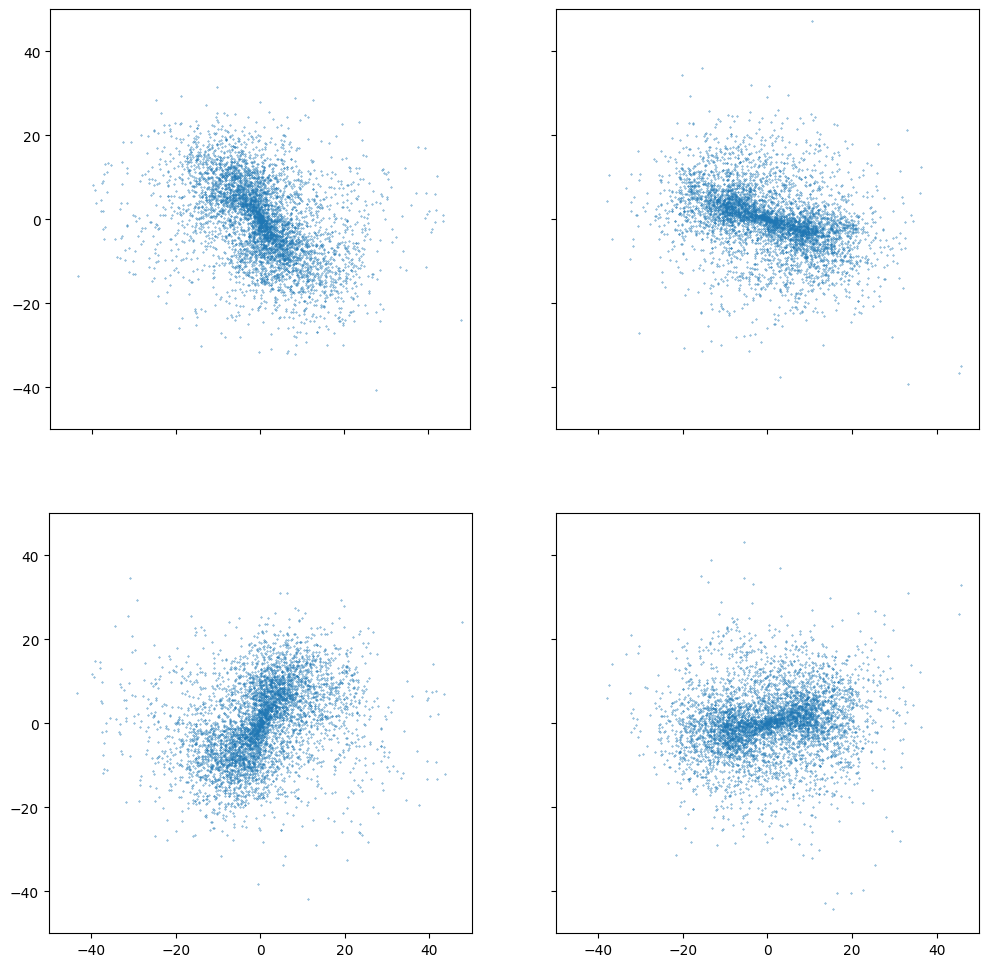

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

sn_ = sn['Naidu21']['lo'][Naidu_idx]
pos_GSE = sn_.part2.pos[in_GSE_RN] - MW_COM_RN
ax[0][0].scatter(pos_GSE[:,0], pos_GSE[:,1], s=0.1)
ax[1][0].scatter(pos_GSE[:,0], pos_GSE[:,2], s=0.1)

sn_ = sn['arepoRN']['lo'][arepo_idx]
pos_GSE = sn_.part2.pos[in_GSE_arepo] - MW_COM_arepo
ax[0][1].scatter(pos_GSE[:,0], pos_GSE[:,1], s=0.1)
ax[1][1].scatter(pos_GSE[:,0], pos_GSE[:,2], s=0.1)

ax[0][0].set_aspect('equal')
ax[0][0].set(xlim=(-50, 50), ylim=(-50, 50))

In [10]:
def bound_fraction(sn, in_GSE, COM, rcut=10):
    pos = sn.part2.pos[in_GSE] - COM
    
    NumGSE = len(np.where(in_GSE)[0])
    
    r = np.linalg.norm(pos, axis=1)
    in_rcut = r < rcut
    NumBound = len(np.where(in_rcut)[0])
    
    return NumBound/NumGSE
    

In [11]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
print(bound_fraction(sn_, in_GSE_RN, GSE_COM_RN))

sn_ = sn['arepoRN']['lo'][arepo_idx]
print(bound_fraction(sn_, in_GSE_arepo, GSE_COM_arepo))

0.28006392329204954
0.33379944067119455


### Lz structure

In [70]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

def get_AngMom(pos, vel, mass, COM, COMV, rcut=8):
    r = np.linalg.norm(pos-COM)
    key = r < rcut
    
    ang = np.cross(pos-COM, vel-COMV)
    ang = np.sum(ang, axis=0)
    ang *= mass
    
    return ang

def get_Lz(sn, sn0, center=np.array([0, 0, 0])):
    
    # plt.scatter(sn_rn0.part2.pos[:,0], sn_rn0.part2.pos[:,1])
    in_MW, in_GSE = get_in_GSE(sn, sn0, center)
    
    pos_MW = sn.part2.pos[in_MW]
    vel_MW = sn.part2.vel[in_MW]
    
    pos_GSE = sn.part2.pos[in_GSE]
    vel_GSE = sn.part2.vel[in_GSE]
    
    MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn, sn0, center)
    
    print('GSE_COM', GSE_COM-MW_COM)
    print('GSE_COMV', GSE_COMV-MW_COMV)
    print('MW_COM', MW_COM)
    print('MW_COMV', MW_COMV)
    
    if sn.MassTable[2] > 0:
        mass_GSE = sn.MassTable[2]
    else:
        mass_GSE = sn.part2.mass[in_GSE][0]

    MW_AngMom = get_AngMom(pos_MW, vel_MW, mass_GSE, MW_COM, MW_COMV)

    ang_mom = MW_AngMom
    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)
    
    # print('MW_COM', MW_COM)
    # print('MW_COMV', MW_COMV)
    # print('MW_AngMom', MW_AngMom)

    pos_GSE = sn.part2.pos[in_GSE] - MW_COM
    vel_GSE = sn.part2.vel[in_GSE] - MW_COMV
    
    pos_MW = sn.part2.pos[in_MW] - MW_COM
    vel_MW = sn.part2.vel[in_MW] - MW_COMV

    pos_GSE_rot = rodrigues_formula(k, pos_GSE.astype(np.float64), theta)
    vel_GSE_rot = rodrigues_formula(k, vel_GSE.astype(np.float64), theta)
    
    pos_MW_rot = rodrigues_formula(k, pos_MW.astype(np.float64), theta)
    vel_MW_rot = rodrigues_formula(k, vel_MW.astype(np.float64), theta)

    pos_GSE_rot[:,0] = - pos_GSE_rot[:,0]
    vel_GSE_rot[:,0] = - vel_GSE_rot[:,0]
    
    Lz = np.cross(pos_GSE_rot, 1.4*vel_GSE_rot)[:,2]
    
    # noisy Lz
    
    gal = coord.Galactocentric(x=pos_GSE_rot[:,0]*u.kpc, 
                               y=pos_GSE_rot[:,1]*u.kpc, 
                               z=pos_GSE_rot[:,2]*u.kpc,
                               v_x=1.4*vel_GSE_rot[:,0]*u.km/u.s, 
                               v_y=1.4*vel_GSE_rot[:,1]*u.km/u.s, 
                               v_z=1.4*vel_GSE_rot[:,2]*u.km/u.s)
    icrs = gal.transform_to(coord.ICRS)

    noisy_dist = np.random.normal(icrs.distance.kpc, 0.1*icrs.distance.kpc)

    noisy_icrs = coord.ICRS(ra=icrs.ra, dec=icrs.dec, distance=noisy_dist*u.kpc,
                pm_ra_cosdec=np.random.normal(icrs.pm_ra_cosdec.value, 0.1*np.abs(icrs.pm_ra_cosdec.value))*u.mas/u.yr, 
                pm_dec=np.random.normal(icrs.pm_dec.value, 0.1*np.abs(icrs.pm_dec.value))*u.mas/u.yr, 
                radial_velocity=icrs.radial_velocity)

    r_gal = np.linalg.norm(pos_GSE_rot, axis=1)
    solar_pos = np.array([-coord.Galactocentric().galcen_distance.value, 0, coord.Galactocentric().z_sun.value/1e+3])
    dist_solar = np.linalg.norm(pos_GSE_rot - solar_pos, axis=1)
    
    dec = noisy_icrs.dec.deg
    b = noisy_icrs.transform_to(coord.Galactic).b.deg
    in_H3 = np.logical_and(dec > -20, np.abs(b) > 40)
    in_H3 = np.logical_and(r_gal < 50, in_H3)
    in_H3 = np.logical_and(dist_solar > 3, in_H3)
    
    
    noisy_gal = noisy_icrs.transform_to(coord.Galactocentric)

    w = gd.PhaseSpacePosition(pos=[noisy_gal.x.value, noisy_gal.y.value, noisy_gal.z.value]*u.kpc, 
                              vel=[noisy_gal.v_x.value, noisy_gal.v_y.value, 
                                   noisy_gal.v_z.value]*u.km/u.s )

    noisy_lz = w.angular_momentum()[2].to(u.kpc*u.km/u.s).value
    noisy_e = (w.energy(gp.MilkyWayPotential()).to(u.km**2/u.s**2)).value
    
    
    return Lz, noisy_lz, in_H3

GSE_COM [ 0.23925781 -0.24224854 -0.00117493]
GSE_COMV [-24.961687  32.596146 -44.02635 ]
MW_COM [ 239.45764  136.21054 -205.08572]
MW_COMV [ 26.429247   8.822013 -16.96857 ]


GSE_COM [-0.13770919  0.01382856  0.04282159]
GSE_COMV [-34.19169338  -8.54700806   3.89237998]
MW_COM [ 245.11819535  146.52085468 -212.28726839]
MW_COMV [ 26.91498443  13.3442703  -23.38299788]


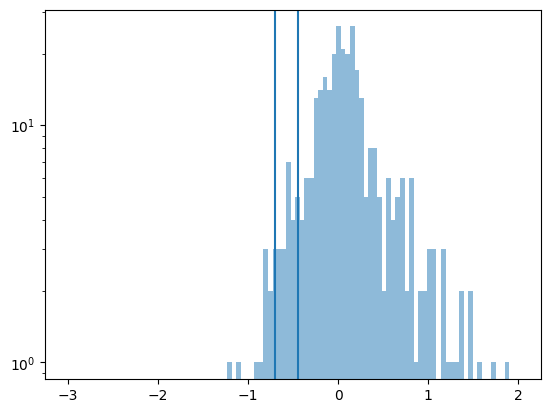

In [71]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
sn_0 = sn['Naidu21']['lo'][0]
Lz_N, Lz_N_noisy, in_H3 = get_Lz(sn_, sn_0)

sn_ = sn['arepoRN']['lo'][arepo_idx]
sn_0 = sn['arepoRN']['lo'][0]
Lz_a, Lz_a_noisy, _ = get_Lz(sn_, sn_0)

plt.hist(Lz_N_noisy[in_H3]/1E3, bins=np.linspace(-3, 2, 100), alpha=0.5);
# plt.hist(Lz_a_noisy/1E3, bins=np.linspace(-3, 2, 100), alpha=0.5);

plt.axvline(-0.7)
plt.axvline(-0.45)
plt.yscale('log')

#### initial R of arjuna material

65006 5006
0.026706231454005934


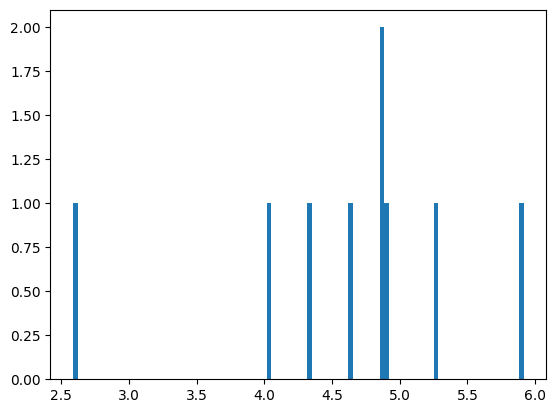

In [74]:
sn_ = sn['Naidu21']['lo'][Naidu_idx]
sn_0 = sn['Naidu21']['lo'][0]
MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_0, sn_0)
in_MW, in_GSE = get_in_GSE(sn_, sn_0, np.array([0, 0, 0]))

print(sn_.NumPart_Total[2], len(Lz_N_noisy))

# arjuna_bool = np.logical_and(Lz_N/1E3 > -0.7, Lz_N < -0.45)
arjuna_bool = np.logical_and(Lz_N_noisy/1E3 > 1.5, in_H3)
arjuna_ids = sn_.part2.id[in_GSE][arjuna_bool]
print(len(arjuna_ids)/len(np.where(in_H3)[0]))

arjuna_ics_ids = sn_0.part2.id
arjuna_ics_keys = np.isin(arjuna_ics_ids, arjuna_ids)

r = np.linalg.norm(sn_0.part2.pos - GSE_COM, axis=1)

plt.hist(r[arjuna_ics_keys], bins=100);


## initial vleocity structure of GSE

In [103]:
galic_ics = arepo.Snapshot('/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010')
mnd_ics = arepo.Snapshot(basepath + 'ics/MWN0_GSEN0/lvlRN-nofs/GSE_ICs.dat')

Warning end of file '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010' not reached yet, but unknowen fields ahead. Thus some items might be missing on the snapshot object.


In [104]:
def get_ellipsoid(ics, Rmin=2, Rmax=3, ptype=2):
    part = getattr(ics, 'part'+str(ptype))
    R = np.linalg.norm(part.pos[:,:2], axis=1)
    cphi = part.pos[:,0]/R
    sphi = part.pos[:,1]/R
    
    velR = part.vel[:,0] * cphi + part.vel[:,1] * sphi
    velphi = part.vel[:,1] * cphi - part.vel[:,0] * sphi
    velz = part.vel[:,2]
    
    key = np.logical_and(R > Rmin, R < Rmax)
    
    print('mean vphi:', np.mean(velphi[key]))
    print('std(vR):', np.std(velR[key]))
    print('std(vz):', np.std(velz[key]))
    
    return None
    

In [105]:
get_ellipsoid(galic_ics, ptype=1)

mean vphi: -0.17080045
std(vR): 55.9322
std(vz): 55.921196


In [106]:
get_ellipsoid(mnd_ics, ptype=1)

mean vphi: 0.50519514
std(vR): 55.91043
std(vz): 56.238922


In [107]:
np.sum(galic_ics.part1.mass[0] * np.cross(galic_ics.part1.pos, galic_ics.part1.vel), axis=0)

array([-3.124257, 49.032234, 26.325304], dtype=float32)

In [108]:
np.sum(mnd_ics.MassTable[1] * np.cross(mnd_ics.part1.pos, mnd_ics.part1.vel), axis=0)

array([12.730915, 25.03513 , 47.74165 ], dtype=float32)

In [82]:
def Menc(ics, rcut=3):
    ans = 0.0
    for ptype in [1, 2, 3]:
        if ics.NumPart_Total[ptype] > 0:
            part = getattr(ics, 'part'+str(ptype))
            r = np.linalg.norm(part.pos, axis=1)
            key = r < rcut
            
            if ics.MassTable[ptype] > 0:
                print(ptype, '0', len(np.where(key)[0]) * ics.MassTable[ptype])
                ans += len(np.where(key)[0]) * ics.MassTable[ptype]
            else:
                print(ptype, '1', np.sum(part.mass[key]))
                ans += np.sum(part.mass[key])
    return ans
        

In [86]:
print(Menc(galic_ics))
print(Menc(mnd_ics))

1 1 0.18292086
2 1 0.040048376
0.22296923398971558
1 0 0.1846367780829305
2 0 0.04015023288213573
0.22478701096506623


# Menc around GSE - contracting?

In [116]:
def Menc(sn, rcut=3, center=np.array([0, 0, 0])):
    ans = {}
    ans[1] = 0.0
    ans[2] = 0.0
    for ptype in [1, 2]:
        if sn.NumPart_Total[ptype] > 0:
            part = getattr(sn, 'part'+str(ptype))
            r = np.linalg.norm(part.pos - center, axis=1)
            key = r < rcut
            
            if sn.MassTable[ptype] > 0:
                ans[ptype] = len(np.where(key)[0]) * sn.MassTable[ptype]
            else:
                ans[ptype] = np.sum(part.mass[key])
    return ans
        

In [124]:
sn_ = sn['Naidu21']['lo'][7]
sn_0 = sn['Naidu21']['lo'][0]
# print(sn_0)

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_, rcut=10, center=GSE_COM))

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_0, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_0, rcut=10, center=GSE_COM))

sn_ = sn['arepoRN']['lo'][140]
sn_0 = sn['arepoRN']['lo'][0]

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_, rcut=10, center=GSE_COM))

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_0, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_0, rcut=10, center=GSE_COM))

{1: 1.6428707, 2: 0.050041728}
{1: 1.3758304, 2: 0.05003172}
{1: 1.92886844 1e+10 Msol, 2: 0.05007524 1e+10 Msol}
{1: 1.42598745 1e+10 Msol, 2: 0.05006523 1e+10 Msol}


In [125]:
sn_ = sn['Naidu21']['lo'][7]
sn_0 = sn['Naidu21']['lo'][0]
# print(sn_0)

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_, rcut=10, center=MW_COM))

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_0, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_0, rcut=10, center=MW_COM))

sn_ = sn['arepoRN']['lo'][140]
sn_0 = sn['arepoRN']['lo'][0]

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_, rcut=10, center=MW_COM))

MW_COM, MW_COMV, GSE_COM, GSE_COMV = get_COM(sn_0, sn_0, center=np.array([0, 0, 0]))
print(Menc(sn_0, rcut=10, center=MW_COM))

{1: 2.0708454, 2: 0.597518}
{1: 1.887596, 2: 0.5974182}
{1: 2.4022152 1e+10 Msol, 2: 0.59821832 1e+10 Msol}
{1: 1.91120355 1e+10 Msol, 2: 0.59753948 1e+10 Msol}


# GSE in isolation

In [172]:
fname = '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010'
ics_rn = arepo.Snapshot(fname)

fname = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/ics/MWN0_GSEN0/lvlRN10x/GSE_ICs.dat'
ics_mnd = arepo.Snapshot(fname)

Warning end of file '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-GEz2_UM_M1_9_10x/snap_010' not reached yet, but unknowen fields ahead. Thus some items might be missing on the snapshot object.


In [175]:
print(ics_rn.NumPart_Total)
print(ics_mnd.NumPart_Total)

print(ics_rn.part1.mass[0], ics_rn.part2.mass[0])
print(ics_mnd.MassTable[1], ics_mnd.MassTable[2])

[       0 21545500    50060        0        0        0]
[       0 21545500    50060        0        0        0]
9.976758e-07 1.0002343e-06
9.979449352380079e-07 1.0005041834571575e-06


In [184]:
def get_circular_velocity_curve(ics, center=np.array([0, 0, 0])):
    dr = 0.5
    rmax = dr
    
    r = {}
    rGSE = {}
    for ptype in [0, 1, 2, 3, 4, 5]:
        if ics.NumPart_Total[ptype] > 0:
            part = getattr(ics, 'part'+str(ptype))
            r[ptype] = np.linalg.norm(part.pos - center, axis=1)
    
    rmax_list = []
    Menc_list = []
    while rmax < 80:
        Menc = 0.0
        for ptype in r.keys():
            part = getattr(ics, 'part'+str(ptype))
            in_rmax = r[ptype] < rmax
            
            if ics.MassTable[ptype] > 0:
                Menc += len(np.where(in_rmax)[0]) * ics.MassTable[ptype]
            else:
                Menc += np.sum(part.mass[in_rmax])
            
        Menc_list.append(Menc)
        rmax_list.append(rmax)
        
        rmax += dr
    
    r = np.array(rmax_list)
    Menc = np.array(Menc_list)
    G = 43018.7
    vcsq = G * Menc / r
    
    return r, vcsq
    

In [185]:
r_rn, vcsq_rn = get_circular_velocity_curve(ics_rn)
r_mnd, vcsq_mnd = get_circular_velocity_curve(ics_mnd)

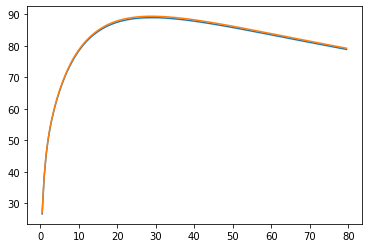

In [187]:
plt.plot(r_rn, np.sqrt(vcsq_rn), label='Naidu+21 ics')
plt.plot(r_mnd, np.sqrt(vcsq_mnd), label='mnd ics')

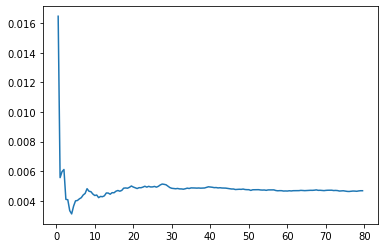

In [189]:
plt.plot(r_rn, (np.sqrt(vcsq_mnd)-np.sqrt(vcsq_rn))/np.sqrt(vcsq_rn))

In [207]:
output_dir = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/GSERNiso/lvlRN/output'
sn_rn = arepo.Snapshot(output_dir, 70, combineFiles=True)

output_dir = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/GSERNiso/lvlMND/output'
sn_mnd = arepo.Snapshot(output_dir, 70, combineFiles=True)

In [208]:
r_rn, vcsq_rn = get_circular_velocity_curve(sn_rn)
r_mnd, vcsq_mnd = get_circular_velocity_curve(sn_mnd)

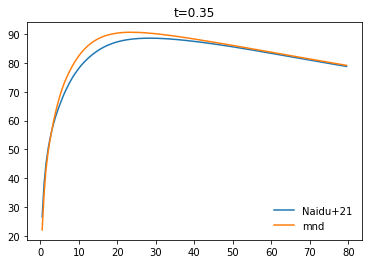

In [214]:
plt.title('t='+str(np.round(sn_rn.Time.value, 3)))
plt.plot(r_rn, np.sqrt(vcsq_rn), label='Naidu+21')
plt.plot(r_mnd, np.sqrt(vcsq_mnd), label='mnd')
plt.legend(frameon=False)
# plt.xlim(-0.1, 4)

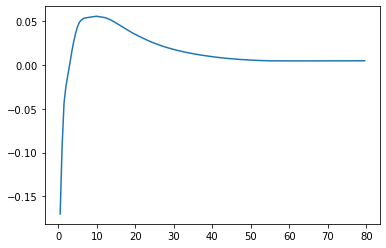

In [216]:
plt.plot(r_rn, (np.sqrt(vcsq_mnd)-np.sqrt(vcsq_rn))/np.sqrt(vcsq_rn))
# plt.xlim(-0.1, 4)
# plt.axvline(0.08)

In [284]:
def get_surf_profile(sn):
    Rave = {}
    surf = {}
    
    for ptype in [1, 2, 3]:
        if sn.NumPart_Total[ptype] == 0:
            continue
        
        surf[ptype] = []
        Rave[ptype] = []
        
        part = getattr(sn, 'part'+str(ptype))
        R = np.linalg.norm(part.pos[:,:2], axis=1)
        
        Rmin = 0.0
        dR = 0.5
        
        while Rmin < 30:
            key = np.logical_and(R > Rmin, R < Rmin + dR)
            
            if sn.MassTable[ptype] > 0:
                Menc = len(np.where(key)[0]) * sn.MassTable[ptype]
            else:
                Menc = np.sum(part.mass[key])
            
            area = np.pi * ((Rmin + dR)**2 - Rmin**2)
            
            surf[ptype].append(Menc/area)
            Rave[ptype].append(np.mean(R[key]))
            
            Rmin += dR
        
        Rave[ptype] = np.array(Rave[ptype])
        surf[ptype] = np.array(surf[ptype])
    
    return Rave, surf
        

In [221]:
Rave_rn, surf_rn = get_surf_profile(sn_rn)
Rave_mnd, surf_mnd = get_surf_profile(sn_mnd)

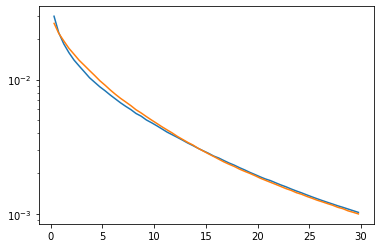

In [223]:
plt.plot(Rave_rn[1], surf_rn[1])
plt.plot(Rave_mnd[1], surf_mnd[1])
plt.yscale('log')

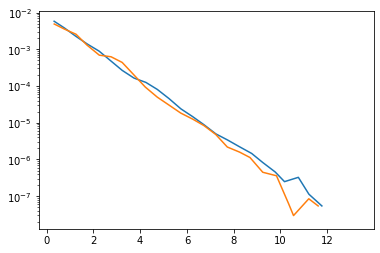

In [224]:
plt.plot(Rave_rn[2], surf_rn[2])
plt.plot(Rave_mnd[2], surf_mnd[2])
plt.yscale('log')

# MW in isolation

#### ics

In [321]:
fname = '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-MWz2_M1_smaller/snap_010'
ics_rn = arepo.Snapshot(fname)

fname = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/ics/MWN0_GSEN0/lvlRN-nofs/MW_ICs.dat'
ics_mnd = arepo.Snapshot(fname)

Warning end of file '/n/holystore01/LABS/conroy_lab/Lab/rnaidu/code/GALIC/Model-MWz2_M1_smaller/snap_010' not reached yet, but unknowen fields ahead. Thus some items might be missing on the snapshot object.


In [322]:
print(ics_rn.NumPart_Total)
print(ics_mnd.NumPart_Total)

print(ics_rn.part1.mass[0], ics_rn.part2.mass[0])
print(ics_mnd.MassTable[1], ics_mnd.MassTable[2])

print(np.sum(ics_rn.part1.mass), ics_mnd.MassTable[1] * ics_mnd.NumPart_Total[1])

[      0 5000000   60000  140000       0       0]
[      0 5000000   60000  140000       0       0]
9.581047e-06 9.980257e-06
9.583632308838175e-06 9.982950321706433e-06
47.905052 47.91816154419088


In [323]:
r_rn, vcsq_rn = get_circular_velocity_curve(ics_rn)
r_mnd, vcsq_mnd = get_circular_velocity_curve(ics_mnd)

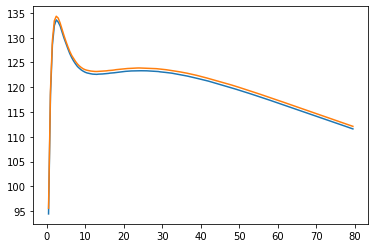

In [324]:
plt.plot(r_rn, np.sqrt(vcsq_rn), label='Naidu+21 ics')
plt.plot(r_mnd, np.sqrt(vcsq_mnd), label='mnd ics')

In [325]:
def get_velocity_profile(ics, ptype=1):
    part = getattr(ics, 'part'+str(ptype))
    pos = part.pos
    vel = part.vel
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    r = np.linalg.norm(pos, axis=1)
    
    theta = np.arctan2(R, pos[:,2])
    phi = np.arctan2(pos[:,1], pos[:,0])
    
    cphi = np.cos(phi)
    sphi = np.sin(phi)
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    velr = stheta*cphi*vel[:,0] + stheta*sphi * vel[:,1] + ctheta * vel[:,2]
    veltheta = ctheta*cphi*vel[:,0] + ctheta*sphi * vel[:,1] - stheta * vel[:,2]
    velphi = -sphi * vel[:,0] + cphi * vel[:,1]
    
    rmin = 0
    dr = 1
    
    mean = {}
    mean['r'] = []
    mean['theta'] = []
    mean['phi'] = []
    
    std = {}
    std['r'] = []
    std['theta'] = []
    std['phi'] = []
    
    rave = []
    
    while rmin < 80:
        key = np.logical_and(r > rmin, r < rmin + dr)
        
        rave.append(np.mean(r[key]))
        
        mean['r'].append(np.mean(velr[key]))
        mean['theta'].append(np.mean(veltheta[key]))
        mean['phi'].append(np.mean(velphi[key]))
        
        std['r'].append(np.std(velr[key]))
        std['theta'].append(np.std(veltheta[key]))
        std['phi'].append(np.std(velphi[key]))
        
        rmin += dr
    
    rave = np.array(rave)
    
    mean['r'] = np.array(mean['r'])
    mean['theta'] = np.array(mean['theta'])
    mean['phi'] = np.array(mean['phi'])
    
    std['r'] = np.array(std['r'])
    std['theta'] = np.array(std['theta'])
    std['phi'] = np.array(std['phi'])
    
    return rave, mean, std
    

In [326]:
r_rn, mean_rn, std_rn = get_velocity_profile(ics_rn)
r_mnd, mean_mnd, std_mnd = get_velocity_profile(ics_mnd)

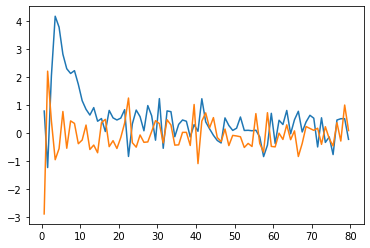

In [327]:
key = 'r'
# key = 'theta'
# key = 'phi'

plt.plot(r_rn, mean_rn[key])
plt.plot(r_mnd, mean_mnd[key])
# plt.ylim(0, None)

(0.0, 125.51212291717529)

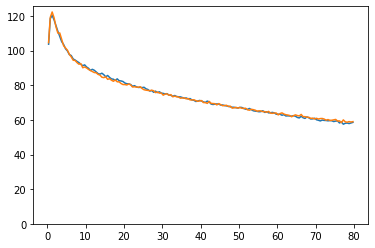

In [291]:
key = 'r'
# key = 'theta'
# key = 'phi'

plt.plot(r_rn, std_rn[key])
plt.plot(r_mnd, std_mnd[key])
plt.ylim(0, None)

#### snapshots

In [300]:
output_dir = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/MWRNiso/lvlRN/output'
sn_rn = arepo.Snapshot(output_dir, 200, combineFiles=True)

output_dir = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/runs/MWRNiso/lvlMND/output'
sn_mnd = arepo.Snapshot(output_dir, 200, combineFiles=True)

In [301]:
r_rn, vcsq_rn = get_circular_velocity_curve(sn_rn)
r_mnd, vcsq_mnd = get_circular_velocity_curve(sn_mnd)

(0.0, 140.39329669798906)

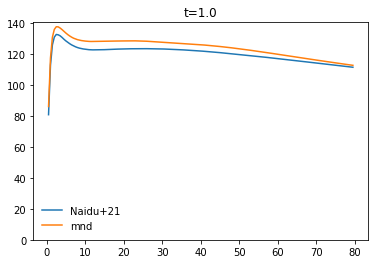

In [302]:
plt.title('t='+str(np.round(sn_rn.Time.value, 3)))
plt.plot(r_rn, np.sqrt(vcsq_rn), label='Naidu+21')
plt.plot(r_mnd, np.sqrt(vcsq_mnd), label='mnd')
plt.legend(frameon=False)
# plt.xlim(-0.1, 4)
plt.ylim(0, None)

In [303]:
Rave_rn, surf_rn = get_surf_profile(sn_rn)
Rave_mnd, surf_mnd = get_surf_profile(sn_mnd)

/n/sw/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/sw/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


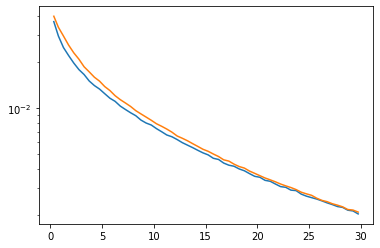

In [304]:
plt.plot(Rave_rn[1], surf_rn[1])
plt.plot(Rave_mnd[1], surf_mnd[1])
plt.yscale('log')

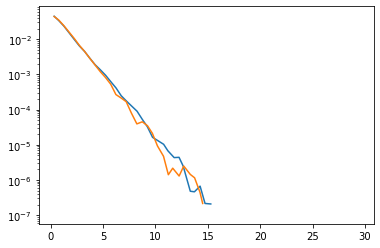

In [305]:
plt.plot(Rave_rn[2], surf_rn[2])
plt.plot(Rave_mnd[2], surf_mnd[2])
plt.yscale('log')

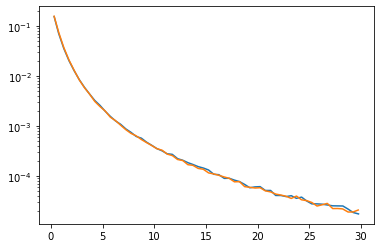

In [306]:
plt.plot(Rave_rn[3], surf_rn[3])
plt.plot(Rave_mnd[3], surf_mnd[3])
plt.yscale('log')